### Load features



In [48]:
import pandas as pd
import pathlib
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data loading
data_dir = pathlib.Path("../data")
featues = data_dir / "train/ml_feature_matrix.csv"
df = pd.read_csv(featues)

df.head()

,subject_id,start_date,measurement_date,target_ffp_status,prev_ffp_status,total_steps_sum,total_steps_mean,total_steps_std,days_exercised,interval_length,longest_active_streak,prop_days_exercised,visit_interval,cumulative_steps,sex,age,ethnicity,race,monthly_income,education,marital_status,living_situation
0,MDE001,2021-07-19,2021-08-23,frail,frail,358.0,9.944444,31.889940,9,36,2,0.250000,1_to_2,358.0,m,83.0,non_hisp,black,3000.0,18.0,never_married,with_others
1,MDE001,2021-08-23,2021-09-15,no_frail,frail,639.0,26.625000,87.482576,11,24,5,0.458333,2_to_3,997.0,m,83.0,non_hisp,black,3000.0,18.0,never_married,with_others
2,MDE001,2021-09-15,2021-10-07,frail,no_frail,235.0,10.217391,13.707850,10,23,6,0.434783,3_to_4,1232.0,m,83.0,non_hisp,black,3000.0,18.0,never_married,with_others
3,MDE001,2021-10-07,2022-01-19,frail,frail,1291.0,13.309278,29.515660,29,97,12,0.298969,4_to_5,2523.0,m,83.0,non_hisp,black,3000.0,18.0,never_married,with_others
4,MDE002,2021-07-21,2021-08-30,no_frail,no_frail,0.0,0.000000,0.000000,0,41,0,0.000000,1_to_2,0.0,m,61.0,non_hisp,white,1033.0,3.0,never_married,alone


### Impute missing values


In [50]:
# Fill missing total_steps_std with 0
df['total_steps_std'] = df['total_steps_std'].fillna(0)

# Fill missing monthly_income with median
median_income = df['monthly_income'].median()
df['monthly_income'] = df['monthly_income'].fillna(median_income)

# Fill missing education with mode
df['education'] = df['education'].fillna(df["education"].mode().iloc[0])

In [51]:
# Check missing values
total_rows = len(df)
missing_summary = df.isnull().sum().to_frame(name='missing_count')
missing_summary['missing_percent'] = (missing_summary['missing_count'] / total_rows * 100).round(2)
missing_summary = missing_summary[missing_summary['missing_count'] > 0].sort_values(by='missing_count', ascending=False)

print(missing_summary)

Empty DataFrame
Columns: [missing_count, missing_percent]
Index: []


In [67]:
df['target_ffp_status']

0         frail
1      no_frail
2         frail
3         frail
4      no_frail
         ...   
206       frail
207       frail
208    no_frail
209    no_frail
210    no_frail
Name: target_ffp_status, Length: 211, dtype: object

In [66]:
le = LabelEncoder()
y = le.fit_transform(df['target_ffp_status'])
print(le.classes_)

['frail' 'no_frail']


## Train


### RandomForest


In [100]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Prepare features and target
X = df.drop(['subject_id', 'start_date', 'measurement_date', 'target_ffp_status'], axis=1)
le = LabelEncoder()
y = le.fit_transform(df['target_ffp_status'])  # 0: frail, 1: no_frail

# Encode categorical features
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro_scores = cross_val_score(clf, X, y, cv=skf, scoring='f1_macro')
accuracy_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')

# print("F1 Macro Scores:", f1_macro_scores)
# 3 floating point numbers
print("\nAverage across folds")
print("-"*20)
print("F1 score:", f1_macro_scores.mean().round(3))
# print("Accuracy Scores:", accuracy_scores)
print("Accuracy:", accuracy_scores.mean().round(3))

# Per-class performance tracking
reports = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Rename class labels: 0 → frail, 1 → no_frail
    df_report = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
    df_report.index = df_report.index.map({'0': 'frail', '1': 'no_frail'})
    df_report['fold'] = fold
    reports.append(df_report)

# Combine and compute averages
final_report_df = pd.concat(reports).reset_index().rename(columns={'index': 'class'})
avg_metrics = final_report_df.groupby('class')[['precision', 'recall', 'f1-score']].mean().round(3)
avg_metrics.loc['average'] = avg_metrics.mean()
avg_metrics


Average across folds
--------------------
F1 score: 0.727
Accuracy: 0.796


,precision,recall,f1-score
class,,,
frail,0.7320,0.5080,0.5890
no_frail,0.8210,0.9130,0.8640
average,0.7765,0.7105,0.7265


Feature ranking:
1. total_steps_mean (0.1166)
2. total_steps_sum (0.1130)
3. total_steps_std (0.1129)
4. prev_ffp_status (0.1041)
5. cumulative_steps (0.0961)
6. age (0.0641)
7. monthly_income (0.0552)
8. interval_length (0.0528)
9. education (0.0527)
10. prop_days_exercised (0.0464)
11. longest_active_streak (0.0403)
12. days_exercised (0.0395)
13. visit_interval (0.0257)
14. living_situation (0.0221)
15. race (0.0216)
16. ethnicity (0.0140)
17. marital_status (0.0132)
18. sex (0.0097)


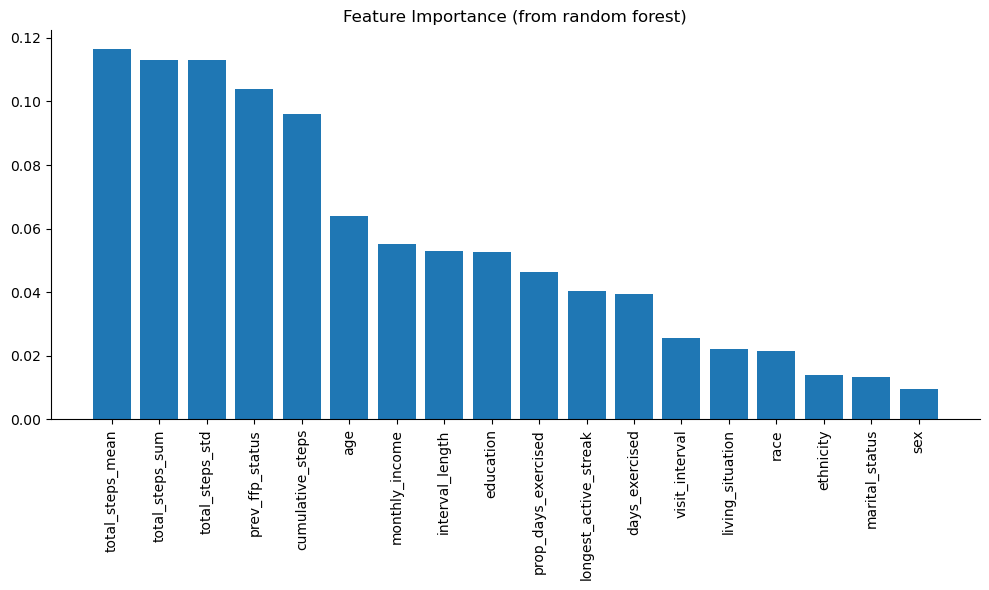

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Fit on all data (or use the last fold's model)
clf.fit(X, y)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {X.columns[indices[f]]} ({importances[indices[f]]:.4f})")

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (from random forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
sns.despine()
plt.show()

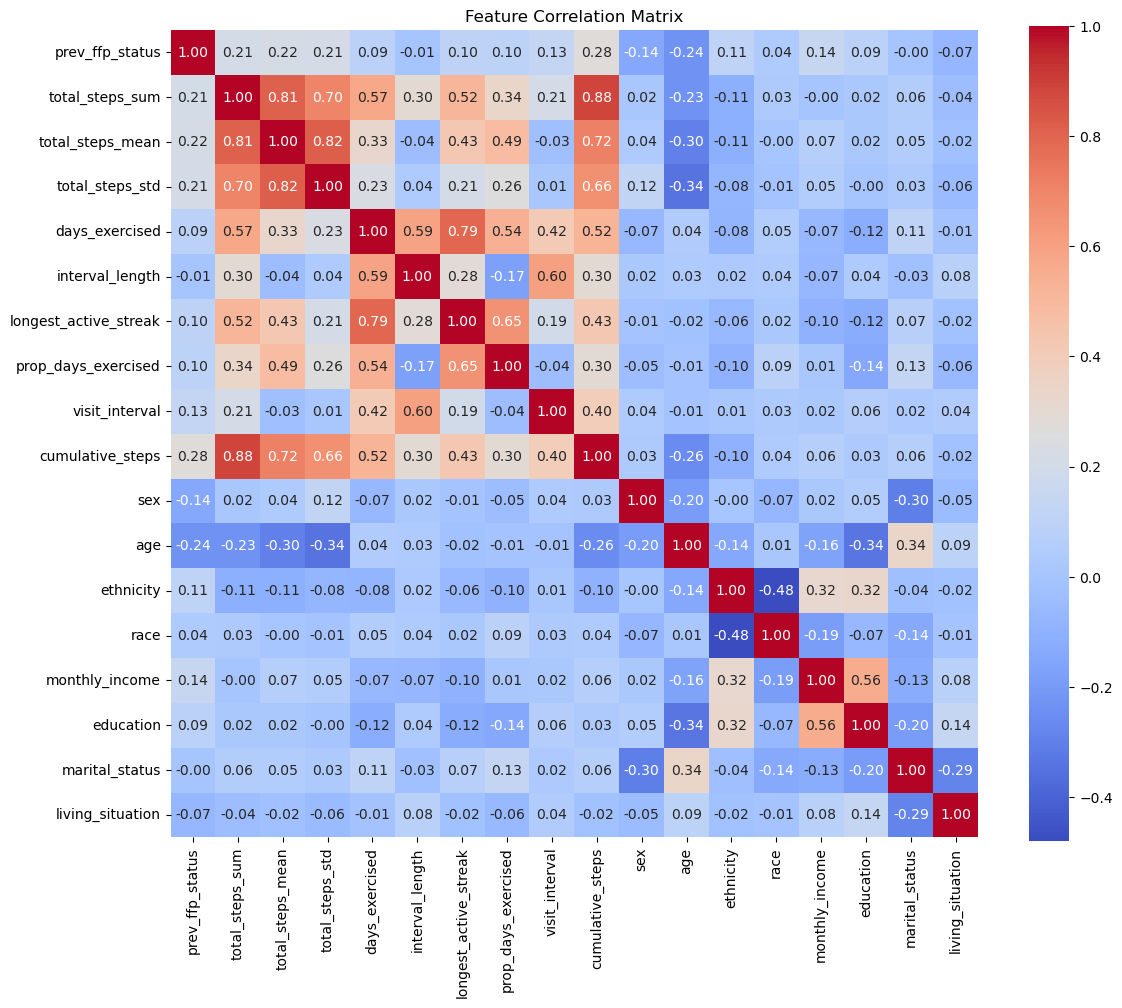

In [64]:
# Plot the correlation matrix
corr = X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### XGBoost

In [104]:
df

,subject_id,start_date,measurement_date,target_ffp_status,prev_ffp_status,total_steps_sum,total_steps_mean,total_steps_std,days_exercised,interval_length,longest_active_streak,prop_days_exercised,visit_interval,cumulative_steps,sex,age,ethnicity,race,monthly_income,education,marital_status,living_situation
0,MDE001,2021-07-19,2021-08-23,frail,frail,358.0,9.944444,31.889940,9,36,2,0.250000,1_to_2,358.0,m,83.0,non_hisp,black,3000.0,18.0,never_married,with_others
1,MDE001,2021-08-23,2021-09-15,no_frail,frail,639.0,26.625000,87.482576,11,24,5,0.458333,2_to_3,997.0,m,83.0,non_hisp,black,3000.0,18.0,never_married,with_others
2,MDE001,2021-09-15,2021-10-07,frail,no_frail,235.0,10.217391,13.707850,10,23,6,0.434783,3_to_4,1232.0,m,83.0,non_hisp,black,3000.0,18.0,never_married,with_others
3,MDE001,2021-10-07,2022-01-19,frail,frail,1291.0,13.309278,29.515660,29,97,12,0.298969,4_to_5,2523.0,m,83.0,non_hisp,black,3000.0,18.0,never_married,with_others
4,MDE002,2021-07-21,2021-08-30,no_frail,no_frail,0.0,0.000000,0.000000,0,41,0,0.000000,1_to_2,0.0,m,61.0,non_hisp,white,1033.0,3.0,never_married,alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,MDE087,2024-01-29,2024-03-01,frail,frail,2673.0,83.531250,81.362187,28,32,24,0.875000,3_to_4,18303.0,f,99.0,hisp,unknown,0.0,3.0,widowed,with_family
207,MDE087,2024-03-01,2024-06-26,frail,frail,12661.0,110.095652,88.755427,109,115,49,0.947826,4_to_5,30964.0,f,99.0,hisp,unknown,0.0,3.0,widowed,with_family
208,MDE088,2023-01-30,2023-12-20,no_frail,no_frail,183138.0,5723.062500,2465.241216,31,32,31,0.968750,1_to_2,183138.0,m,71.0,hisp,unknown,700.0,2.0,married,with_family
209,MDE089,2024-01-25,2024-02-29,no_frail,no_frail,194433.0,6076.031250,2179.302071,31,32,31,0.968750,3_to_4,194433.0,f,69.0,hisp,white,1000.0,14.0,never_married,with_family


In [ ]:
import xgboost as xgb

# Load xgboost
clf = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=3,
    random_state=42,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1 
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro_scores = cross_val_score(clf, X, y, cv=skf, scoring='f1_macro')
accuracy_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')

print("\nAverage across folds")
print("-"*20)
print("F1 score:", f1_macro_scores.mean().round(3))
print("Accuracy:", accuracy_scores.mean().round(3))

reports = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
    df_report.index = df_report.index.map({'0': 'frail', '1': 'no_frail'})
    df_report['fold'] = fold
    reports.append(df_report)

final_report_df = pd.concat(reports).reset_index().rename(columns={'index': 'class'})
avg_metrics = final_report_df.groupby('class')[['precision', 'recall', 'f1-score']].mean().round(3)
avg_metrics.loc['average'] = avg_metrics.mean()
avg_metrics


Average across folds
--------------------
F1 score: 0.69
Accuracy: 0.763


,precision,recall,f1-score
class,,,
frail,0.6030,0.491,0.54
no_frail,0.8100,0.873,0.84
average,0.7065,0.682,0.69


In [108]:
import xgboost as xgb

# Load xgboost
scale = (y == 1).sum() / (y == 0).sum()
clf = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=3,
    random_state=42,
    scale_pos_weight=scale,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1 
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro_scores = cross_val_score(clf, X, y, cv=skf, scoring='f1_macro')
accuracy_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')

print("\nAverage across folds")
print("-"*20)
print("F1 score:", f1_macro_scores.mean().round(3))
print("Accuracy:", accuracy_scores.mean().round(3))

reports = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
    df_report.index = df_report.index.map({'0': 'frail', '1': 'no_frail'})
    df_report['fold'] = fold
    reports.append(df_report)

final_report_df = pd.concat(reports).reset_index().rename(columns={'index': 'class'})
avg_metrics = final_report_df.groupby('class')[['precision', 'recall', 'f1-score']].mean().round(3)
avg_metrics.loc['average'] = avg_metrics.mean()
avg_metrics


Average across folds
--------------------
F1 score: 0.716
Accuracy: 0.796


,precision,recall,f1-score
class,,,
frail,0.6890,0.492,0.566
no_frail,0.8200,0.920,0.866
average,0.7545,0.706,0.716


In [109]:
import xgboost as xgb

# Load xgboost
scale = (y == 1).sum() / (y == 0).sum()
clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=42,
    scale_pos_weight=scale,
    use_label_encoder=False,
    eval_metric='logloss',
    early_stopping_rounds=10,
    n_jobs=-1 
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro_scores = cross_val_score(clf, X, y, cv=skf, scoring='f1_macro')
accuracy_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')

print("\nAverage across folds")
print("-"*20)
print("F1 score:", f1_macro_scores.mean().round(3))
print("Accuracy:", accuracy_scores.mean().round(3))

reports = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
    df_report.index = df_report.index.map({'0': 'frail', '1': 'no_frail'})
    df_report['fold'] = fold
    reports.append(df_report)

final_report_df = pd.concat(reports).reset_index().rename(columns={'index': 'class'})
avg_metrics = final_report_df.groupby('class')[['precision', 'recall', 'f1-score']].mean().round(3)
avg_metrics.loc['average'] = avg_metrics.mean()
avg_metrics


Average across folds
--------------------
F1 score: 0.701
Accuracy: 0.773


,precision,recall,f1-score
class,,,
frail,0.634,0.4940,0.5540
no_frail,0.812,0.8870,0.8470
average,0.723,0.6905,0.7005


In [110]:
from sklearn.feature_selection import SelectFromModel

# Fit model
clf = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
clf.fit(X, y)

# Automatic feature selection
selector = SelectFromModel(clf, threshold="median", prefit=True)
X_selected = selector.transform(X)

# You can get selected feature names:
selected_features = X.columns[selector.get_support()]

In [111]:
selected_features

Index(['prev_ffp_status', 'total_steps_sum', 'total_steps_mean',
       'longest_active_streak', 'prop_days_exercised', 'cumulative_steps',
       'race', 'education', 'living_situation'],
      dtype='object')